# Data Loading and Cleaning

In [145]:
# imports
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os
import sklearn
import string as str
import re

In [39]:
# Loading csv with preprocessed data
df = pd.read_csv('Preprocessed_data.csv')

# Cleaning the data
# Removing zero ratings
df = df[df['rating'] != 0]

In [40]:
# Removing image_url columns because we will not use it.
df = df.drop(['img_s'], axis=1)
df = df.drop(['img_m'], axis=1)
df = df.drop(['img_l'], axis=1)
df = df.dropna()

In [41]:
df

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Summary,Language,Category,city,state,country
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
5,5,67544,"toronto, ontario, canada",30.0000,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],toronto,ontario,canada
9,9,123629,"kingston, ontario, canada",34.7439,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],kingston,ontario,canada
11,11,200273,"comber, ontario, canada",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],comber,ontario,canada
12,12,210926,"guelph, ontario, canada",34.7439,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],guelph,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031169,1031169,278851,"dallas, texas, usa",33.0000,067161746X,7,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987.0,Pocket Books,A tongue-in-cheek survival guide for single pe...,en,['Humor'],dallas,texas,usa
1031171,1031171,278851,"dallas, texas, usa",33.0000,0767907566,5,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,A daring twist on the travel-adventure genre t...,en,['Nature'],dallas,texas,usa
1031172,1031172,278851,"dallas, texas, usa",33.0000,0884159221,7,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Lone Star Books,9,9,9,dallas,texas,usa
1031173,1031173,278851,"dallas, texas, usa",33.0000,0912333022,7,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,These hilarious stories by the creator of publ...,en,['Fiction'],dallas,texas,usa


In [5]:
df.to_csv('Preprocessed_data_cleaned.csv', index=False)

In [6]:
# From now on we can work with df or load from the beggining 
# the Preprocessed_data_cleaned.csv file

-------------------------------------------------------------------
# Demographic Filtering

In [39]:
# Loading csv with book rating data
df_book_rating = pd.read_csv('BX-Book-Ratings.csv', sep=';',encoding= 'unicode_escape', engine='python')

#turns column to int
df_book_rating['Book-Rating']=[int(df_book_rating['Book-Rating'][rating].replace("'", '')) for rating in range(len(df_book_rating['Book-Rating']))]

# remove rows that have 0 as rating
df_book_rating = df_book_rating[df_book_rating['Book-Rating'] != 0]
df_book_rating=df_book_rating.reset_index(drop=True)
df_book_rating['ISBN']=[df_book_rating['ISBN'][rating].replace("'", '') for rating in range(len(df_book_rating['ISBN']))]

At this point we have cleaned and loaded the 2 dataframes that contain all the information we need to proceed.The 'Book-Ratings.csv' contains the ratings each user has appointed to books (the books are identified by ISBN). We will use this dataframe to calculate how many ratings each book has, as well as the average rating of each book. Also, we correlate these 2 values in a 'weighted rating score'. More specifically, this score takes into account both the number of ratings and the average rating. We chose the formula below, which is being used to calculate an according score for movies on IMDB website.

We will start using the weighted rating (WR) that IMDB is using, which is given as: 

Weighted Rating(WR)=(v/(v+m))*R)+((m/(v+m))*C)

where: 

* v is the number of votes per book
* m is the minimum votes required to be listed in the chart
* R is the average rating of the book
* C is the mean vote accrose the whole dataframe


In [40]:
#counts the number of ratings and puts them in to new dataframe
isbn_dict=Counter(df_book_rating['ISBN'])

df_isbn_votecount = pd.DataFrame(list(isbn_dict.items()), columns = ['ISBN', 'Vote-Count'])

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a book to feature in the charts, it must have more votes than at least 90% of the booksin the list.

In [41]:
m= df_isbn_votecount['Vote-Count'].quantile(0.9)
isbn_votecount = df_isbn_votecount[df_isbn_votecount['Vote-Count'] >= m]
isbn_votecount=isbn_votecount.reset_index(drop=True)
print('The cut-off is {} and the cleaned dataframe contains {} rows.' .format(m,isbn_votecount.shape[0]))

The cut-off is 4.0 and the cleaned dataframe contains 19918 rows.


Now we will calculate the average rating of each book.

In [42]:
#merging the dataframes
df_custom_rating= pd.merge(isbn_votecount,df_book_rating, how='inner', on=['ISBN'])

#Crearing out the user column because we don't need it
df_custom_rating= df_custom_rating.drop(columns='User-ID')

#Calculates the mean value of all the row with the same ISBN, hence the average rating which is put to the column 'Vote-Average'
df_custom_rating['Vote-Average'] = df_custom_rating['Book-Rating'].groupby(df_custom_rating['ISBN']).transform('mean')

#Deletes the duplicates and 'Book-Rating' column because we do not need them
df_custom_rating =df_custom_rating.drop_duplicates(subset='ISBN', keep='first')
df_custom_rating =df_custom_rating.drop(['Book-Rating'], axis=1)

df_custom_rating.reset_index(drop=True)

,ISBN,Vote-Count,Vote-Average
0,3257224281,4,6.750000
1,038550120X,81,7.580247
2,0060517794,30,8.000000
3,0671537458,17,7.176471
4,0679776818,21,7.476190
...,...,...,...
19913,3250600571,4,9.000000
19914,0886775809,4,8.000000
19915,0375700110,4,6.500000
19916,0451450019,4,8.000000


Above we see the generated values for the average rating of each book. Now, it is time to calculate the weighted score mentioned before. For that we need the C value, which is the mean vote across the dataframe. Then we define a function according to the formula mentioned above and then we generate the weighted score for each book.

In [43]:
C= df_custom_rating['Vote-Average'].mean()
print('The value of C is: {}'.format(C))

#Weighted score function
def weighted_rating(x, m=m, C=C):
    v = x['Vote-Count']
    R = x['Vote-Average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C) ##maybe another function for books

df_custom_rating['Score']=weighted_rating(df_custom_rating, m=m, C=C)

df_custom_rating = df_custom_rating.sort_values('Score', ascending=False)
df_custom_rating

The value of C is: 7.653260512915499


,ISBN,Vote-Count,Vote-Average,Score
144901,0439425220,23,9.869565,9.541224
141498,0618002235,25,9.720000,9.434932
175300,0060256656,20,9.750000,9.400543
211100,0836213319,13,9.923077,9.389002
63913,8826703132,21,9.714286,9.384522
...,...,...,...,...
159321,3932069145,4,3.000000,5.326630
203380,1552781631,4,3.000000,5.326630
189493,349222539X,6,3.666667,5.261304
172663,1880985055,9,3.000000,4.431772


Above we see the generated values for the weighted score. It would be nice, however, if we could see which book they are refering to without having to search with the ISBN code. For this reason we add the 'BX_Books.csv as a dataframe, which contains the titles of the books according to their ISBN, amongst other information as well. With this dataframe we can link the title of each book and display it on the above dataframe.

In [44]:
books_df=pd.read_csv('BX_Books.csv', sep=';',encoding= 'unicode_escape', engine='python')

books_df = books_df.drop(columns=["Unnamed: 5",'Unnamed: 6', "Unnamed: 7","Unnamed: 8", "Unnamed: 9"])

#cleaning the punctuation off the words 
books_df["'ISBN'"]=[books_df["'ISBN'"][i].replace("'", '') for i in range(len(books_df["'ISBN'"]))]
books_df= books_df.rename(columns={"'ISBN'": 'ISBN', "'Book-Title'": 'Book-Title'})

#merging the information we need
intersection_df = pd.merge(books_df,df_custom_rating, how='inner', on=['ISBN'])
intersection_df = intersection_df.drop(columns=["'Book-Author'","'Year-Of-Publication'","'Publisher'"])

#passing the dataframe to csv so we can work with that later
intersection_df.to_csv('Books_Votes_Score.csv', index=False)

intersection_df = intersection_df.sort_values('Vote-Count', ascending=False)
intersection_df=intersection_df.reset_index(drop=True)
intersection_df

,ISBN,Book-Title,Vote-Count,Vote-Average,Score
0,0316666343,'The Lovely Bones: A Novel',707,8.185290,8.182297
1,0971880107,'Wild Animus',581,4.390706,4.413014
2,0385504209,'The Da Vinci Code',487,8.435318,8.428947
3,0312195516,'The Red Tent (Bestselling Backlist)',383,8.182768,8.177295
4,0060928336,'Divine Secrets of the Ya-Ya Sisterhood: A Novel',320,7.887500,7.884608
...,...,...,...,...,...
18695,0486280500,'A Portrait of the Artist As a Young Man (Dove...,4,7.250000,7.451630
18696,0140421998,'Leaves of Grass (Penguin Classics)',4,7.750000,7.701630
18697,0864425295,"'Brief Encounters: stories of love, sex & travel'",4,6.500000,7.076630
18698,0395401461,'Miss Nelson Is Missing!',4,7.500000,7.576630


In [52]:
intersection_df = intersection_df.sort_values('Score', ascending=False)
intersection_df=intersection_df.reset_index(drop=True)

[Text(0.5, 1.0, 'Top 10 recommended books ever!')]

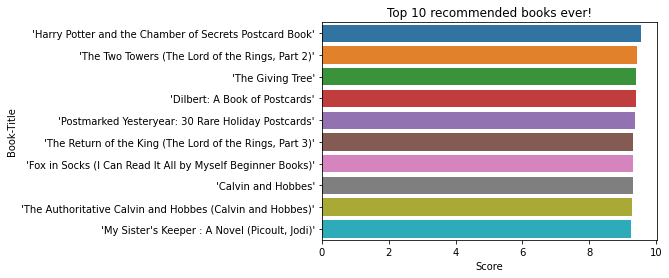

In [51]:
top_10= intersection_df.head(10)
sb.barplot(x = "Score", y = "Book-Title", data = top_10).set(title = "Top 10 recommended books ever!")

So, according to the users of this dataset, wherever you are from, make sure to read these books first!

### By country

Next we find the top books by country. Is essentially the same as above however we implement it by adding an extra column and joining the isbn with the country in order to create the popularity demographic diagrams.

In [2]:
# Loading csv with preprocessed data cleaned
df_cleaned = pd.read_csv('Preprocessed_data_cleaned.csv')


df_cleaned = df_cleaned[df_cleaned['country'] != ',']
df_cleaned = df_cleaned[df_cleaned['country'] != '\"n/a\""']
df_cleaned= df_cleaned.drop(columns=['user_id','Unnamed: 0','publisher','location','Language','Summary','year_of_publication','Category','city','state'])



df_cleaned['country']=df_cleaned['country'].str.split(',').str[-1]
df_cleaned['country']= df_cleaned['country'].replace(r' united kingdom',r'united kingdom')
df_cleaned['country']= df_cleaned['country'].replace(r'\"n/a\""',r'unknown')
df_cleaned= df_cleaned.sort_values(by=['country'],ascending=True)
df_cleaned=df_cleaned.reset_index(drop=True)
(df_cleaned['country']=='\"n/a\""').sum()
df_cleaned

,age,isbn,rating,book_title,book_author,country
0,33.0000,0140310657,10,The TV Kid (Puffin Books),Betsy Byars,australia
1,14.0000,0713100788,9,Discovering Greek Mythology (Woburn Educationa...,P. Kenneth Corsar,australia
2,33.0000,0140328262,10,The Paw Thing (Puffin Books),Paul Jennings,australia
3,13.0000,0340634448,5,The Cowboy Guide,Wayne Caba,australia
4,18.0000,0590454471,2,Picklemania (School Daze),Jerry Spinelli,australia
...,...,...,...,...,...,...
359445,21.0000,185326895X,8,Complete Works of William Shakespeare (Wordswo...,William Shakespeare,yugoslavia
359446,34.7439,0671000306,8,Shock Wave (Dirk Pitt Adventures (Paperback)),Clive Cussler,yugoslavia
359447,20.0000,0971880107,3,Wild Animus,Rich Shapero,yugoslavia
359448,55.0000,0671042858,7,The Girl Who Loved Tom Gordon,Stephen King,zambia


In [3]:
## The exact same process as 
df_cleaned['isbn-country'] = df_cleaned[['isbn', 'country']].agg('-'.join, axis=1)

In [4]:
#counts the number of ratings in each country and puts them in to new dataframe

isbn_dict1=Counter(df_cleaned['isbn-country'])

df_cleaned_isbn_votecount = pd.DataFrame(list(isbn_dict1.items()), columns = ['isbn-country', 'Vote-Count'])

In [5]:
m= df_cleaned_isbn_votecount['Vote-Count'].quantile(0.9)
isbn_votecount_bycountry = df_cleaned_isbn_votecount[df_cleaned_isbn_votecount['Vote-Count'] >= m]
isbn_votecount_bycountry=isbn_votecount_bycountry.reset_index(drop=True)
print('The cut-off is {} and the cleaned dataframe contains {} rows.' .format(m,isbn_votecount_bycountry.shape[0]))

The cut-off is 3.0 and the cleaned dataframe contains 23448 rows.


In [6]:
#merging the dataframes
df_rating_bycountry= pd.merge(isbn_votecount_bycountry,df_cleaned, how='inner', on=['isbn-country'])

#Calculates the mean value of all the row with the same ISBN, hence the average rating which is put to the column 'Vote-Average'
df_rating_bycountry['Vote-Average-By-Country'] = df_rating_bycountry['rating'].groupby(df_rating_bycountry['isbn-country']).transform('mean')

#Deletes the duplicates and 'Book-Rating' column because we do not need them
df_rating_bycountry =df_rating_bycountry.drop_duplicates(subset='isbn-country', keep='first')
df_rating_bycountry =df_rating_bycountry.drop(['rating'], axis=1)

df_rating_bycountry.reset_index(drop=True)

,isbn-country,Vote-Count,age,isbn,book_title,book_author,country,Vote-Average-By-Country
0,0091842050-australia,7,13.0000,0091842050,The Blue Day Book: A Lesson in Cheering Yourse...,Bradley Trevor Greive,australia,9.000000
1,0684872153-australia,3,29.0000,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,australia,6.333333
2,0452282152-australia,7,34.7439,0452282152,Girl with a Pearl Earring,Tracy Chevalier,australia,9.285714
3,0552998486-australia,9,17.0000,0552998486,Chocolat,Joanne Harris,australia,8.222222
4,0099740516-australia,5,39.0000,0099740516,Fall on Your Knees,Ann-Marie MacDonald,australia,7.200000
...,...,...,...,...,...,...,...,...
23443,0684865114-usa,7,34.7439,0684865114,The Restraint of Beasts,Magnus Mills,usa,7.428571
23444,0553577905-usa,3,19.0000,0553577905,Windhaven,George R. R. Martin,usa,7.000000
23445,0451402391-usa,6,34.7439,0451402391,The Search for the Green River Killer,Carlton Smith,usa,8.166667
23446,0060393823-usa,8,34.7439,0060393823,Lost,Gregory Maguire,usa,6.125000


In [7]:
C= df_rating_bycountry['Vote-Average-By-Country'].mean()
print('The value of C is: {}'.format(C))

#Weighted score function
def weighted_rating(x, m=m, C=C):
    v = x['Vote-Count']
    R = x['Vote-Average-By-Country']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C) ##maybe another function for books

df_rating_bycountry['Score']=weighted_rating(df_rating_bycountry, m=m, C=C)

df_rating_bycountry = df_rating_bycountry.sort_values('Score', ascending=False)
df_rating_bycountry

The value of C is: 7.672355126591276


,isbn-country,Vote-Count,age,isbn,book_title,book_author,country,Vote-Average-By-Country,Score
126594,0439425220-usa,18,29.0000,0439425220,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,usa,9.833333,9.524622
125663,0060256656-usa,17,37.0000,0060256656,The Giving Tree,Shel Silverstein,usa,9.823529,9.500853
64414,0836220889-usa,12,33.0000,0836220889,Calvin and Hobbes,Bill Watterson,usa,9.916667,9.467804
181025,0394800389-usa,12,28.0000,0394800389,Fox in Socks (I Can Read It All by Myself Begi...,Dr. Seuss,usa,9.833333,9.401138
86284,0439139597-usa,118,34.7439,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,usa,9.415254,9.372042
...,...,...,...,...,...,...,...,...,...
589,0971880107-australia,57,30.0000,0971880107,Wild Animus,Rich Shapero,australia,4.385965,4.550284
25660,1880985055-usa,5,34.7439,1880985055,Black Coffee Blues,Rollins,usa,2.600000,4.502133
96917,0971880107-usa,296,53.0000,0971880107,Wild Animus,Rich Shapero,usa,4.347973,4.381328
11871,0971880107-canada,53,34.7439,0971880107,Wild Animus,Rich Shapero,canada,4.188679,4.375305


Now that we have the complete dataframe, we can visualize the ratio of the weighted scores vs the number of votes for each country. This way we can see which country is more active accordign to our dataframe. 

In [ ]:
country_array= df_rating_bycountry["country"].drop_duplicates()
country_array= country_counts.reset_index(drop=True)
country_list= list(country_array)
country_list

In [ ]:
def suggest_top_10_books_by_country(country_from_user):
    if country_from_user in country_list:
        choose_country_df = df_rating_bycountry[df_rating_bycountry["country"] == country_from_user]
        choose_country_df =choose_country_df.sort_values('Score', ascending=False)
        top_10= choose_country_df.head(10)
        sb.barplot(x = "Score", y = "book_title", data = top_10).set(title = f"Top 10 recommended books in {country_from_user}", xlim=(7,10))
       
    else:
        print(f'Country not in the list, please choose one of the following:\n{country_array}')
        country_from_user = input('Type a country:')
        suggest_top_10_books_by_country(country_from_user)
    return

Things get interactive here. By running this code you as a user have to type in a country from the country column
above. Then as a demographic result you get the ten best books by the country you input. If the country doesn't exist in the list, we print you the list with the existing countries and as a user you are called to retype a country and get the results.

!NOTE! the code below stops only when you type in an existing country. In case you want to make it stop running after inputing a non existing country, you have to do it manually.

Type a country:
Country not in the list, please choose one of the following:
0                usa
1     united kingdom
2             canada
3            germany
4              spain
5             france
6           malaysia
7          australia
8              italy
9        philippines
10       switzerland
11          portugal
12           romania
13              iran
14           finland
15       new zealand
16       netherlands
17            brazil
18           austria
19         indonesia
20             india
21            poland
22           ireland
Name: country, dtype: object
Type a country:spain


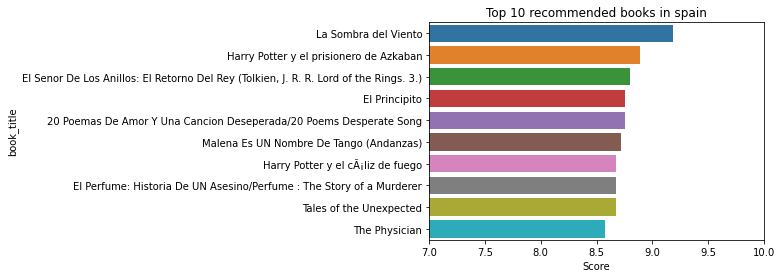

In [161]:
country_from_user = input('Type a country:')
suggest_top_10_books_by_country(country_from_user)

In [ ]:
italy_df = df_rating_bycountry[df_rating_bycountry["country"] == 'italy']
italy_df =italy_df.sort_values('Score', ascending=False)
df_rating_bycountry.plot.bar(x='country', y=['Vote-Count','Score'], color=['maroon','orange'],figsize=(20,20))

<AxesSubplot:xlabel='book_title'>

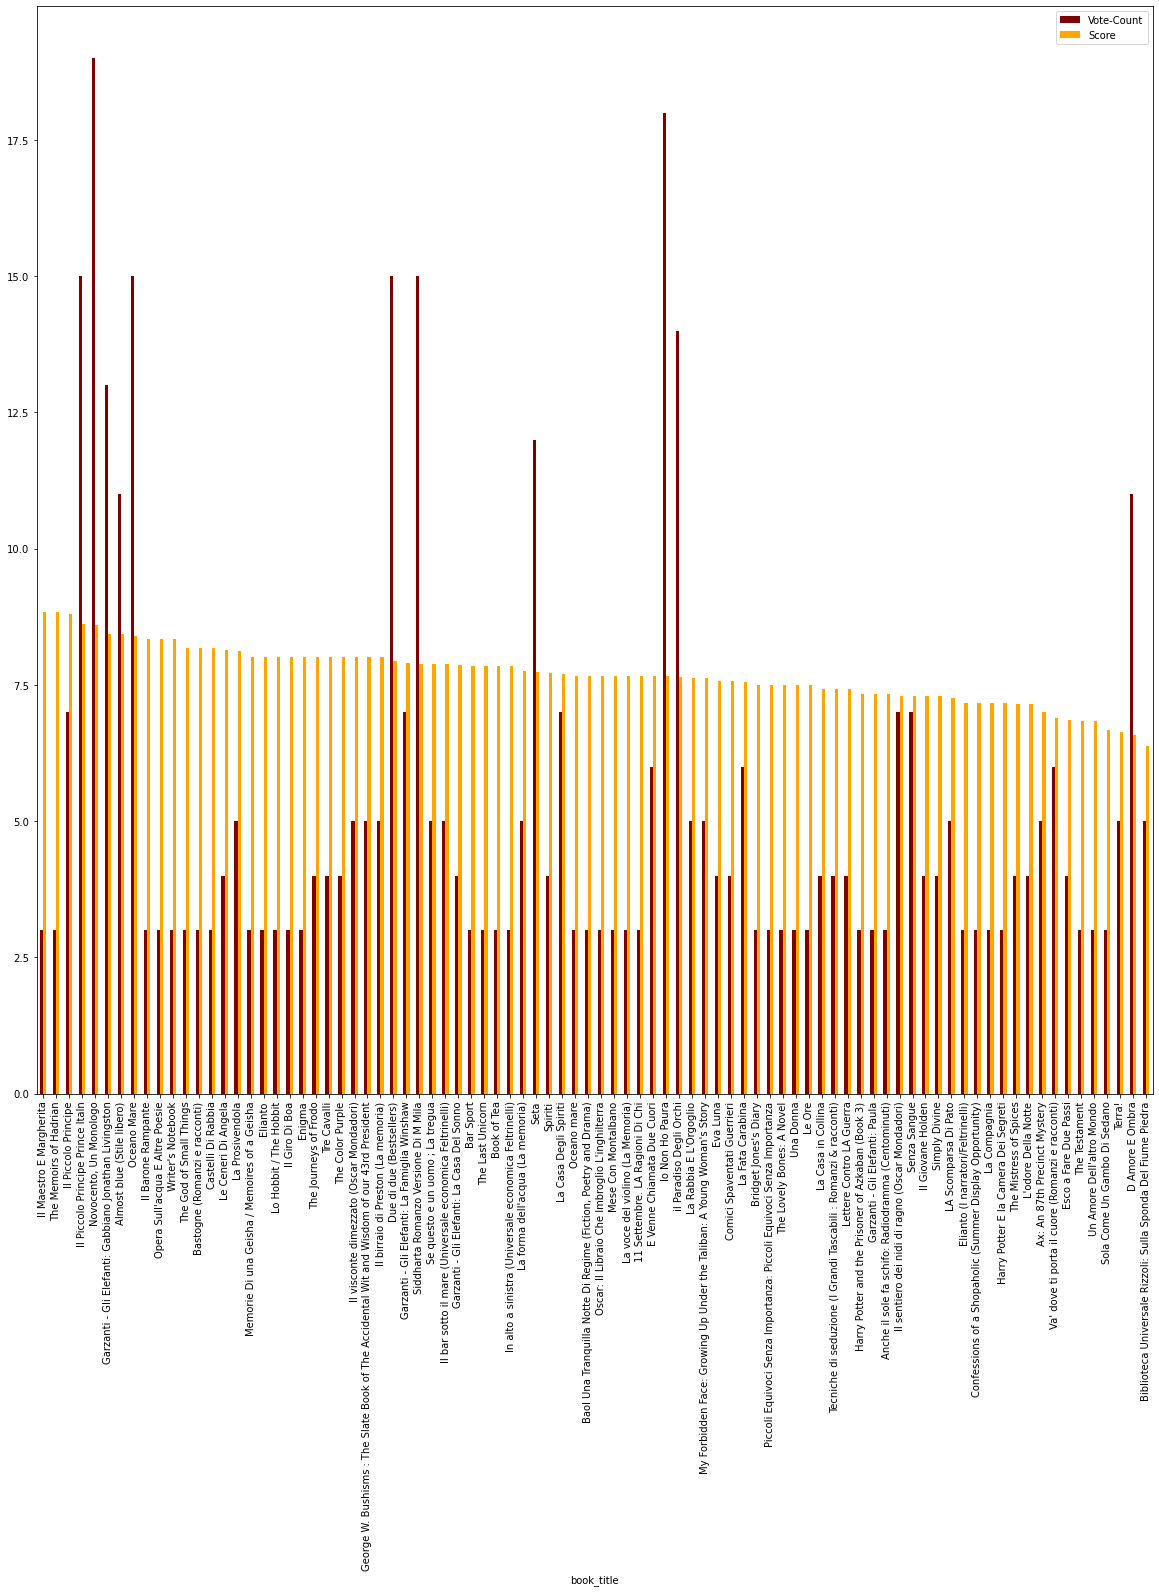

In [10]:
## Took Italy as an example.
italy_df = df_rating_bycountry[df_rating_bycountry["country"] == 'italy']
italy_df =italy_df.sort_values('Score', ascending=False)
italy_df.plot.bar(x='book_title', y=['Vote-Count','Score'], color=['maroon','orange'],figsize=(20,20))

-----------------------------------------------------------
# Content Filtering

In [63]:
# Loading csv with preprocessed data cleaned
# Here add your path to the Preprocessed_data_cleaned.csv file!
# You just need to run the first and this cell from now on everytime you want to run
# the code
df_cleaned = pd.read_csv('/Users/mep/Desktop/mep/CompTools/BookRecommendationSystem/Preprocessed_data_cleaned.csv')

--------------------------------------------------------------------------------
# Collaborative Filtering

In [ ]:
# Loading csv with preprocessed data cleaned
# Here add your path to the Preprocessed_data_cleaned.csv file!
# You just need to run the first and this cell from now on everytime you want to run
# the code
df_cleaned = pd.read_csv('/Users/mep/Desktop/mep/CompTools/BookRecommendationSystem/Preprocessed_data_cleaned.csv')